# Load libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import seaborn as sns 
from imblearn.over_sampling import SMOTE
# For interpretability
import shap
import matplotlib.pyplot as plt

In [2]:
# Settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load data

In [3]:
df = pd.read_csv("../data/raw/ibm_attrition_plus_succession_reordered.csv", sep=";")


In [4]:
df.head(10)

,EmployeeNumber,EmployeeCount,Age,Gender,MaritalStatus,Education,EducationField,Over18,StandardHours,BusinessTravel,...,EnvironmentSatisfaction,WorkLifeBalance,JobInvolvement,OverTime,Attrition,TargetRole,LeadershipScore,CulturalFitScore,PotentialRating,SuccessorReady
0,1,1,41,Female,Single,2,Life Sciences,Y,80,Travel_Rarely,...,2,1,3,Yes,Yes,Sales Manager,4,2,Low,0
1,2,1,49,Male,Married,1,Life Sciences,Y,80,Travel_Frequently,...,3,3,2,No,No,Research Manager,5,2,High,1
2,4,1,37,Male,Single,2,Other,Y,80,Travel_Rarely,...,4,3,2,Yes,Yes,Sr Technician,3,3,High,0
3,5,1,33,Female,Married,4,Life Sciences,Y,80,Travel_Frequently,...,4,3,3,Yes,No,Research Manager,5,5,Low,0
4,7,1,27,Male,Married,1,Medical,Y,80,Travel_Rarely,...,1,3,3,No,No,Sr Technician,5,2,High,0
5,8,1,32,Male,Single,2,Life Sciences,Y,80,Travel_Frequently,...,4,2,3,No,No,Sr Technician,2,4,Medium,0
6,10,1,59,Female,Married,3,Medical,Y,80,Travel_Rarely,...,3,2,4,Yes,No,Sr Technician,3,2,Medium,0
7,11,1,30,Male,Divorced,1,Life Sciences,Y,80,Travel_Rarely,...,4,3,3,No,No,Sr Technician,3,5,High,0
8,12,1,38,Male,Single,3,Life Sciences,Y,80,Travel_Frequently,...,4,3,2,No,No,VP Manufacturing,3,5,Medium,0
9,13,1,36,Male,Married,3,Medical,Y,80,Travel_Rarely,...,3,2,3,No,No,Team Lead,5,4,Low,0


In [5]:
df.shape


(1470, 35)

In [6]:
print(df.columns.tolist())

['EmployeeNumber', 'EmployeeCount', 'Age', 'Gender', 'MaritalStatus', 'Education', 'EducationField', 'Over18', 'StandardHours', 'BusinessTravel', 'Department', 'JobRole', 'JobLevel', 'MonthlyIncome', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager', 'TotalWorkingYears', 'NumCompaniesWorked', 'TrainingTimesLastYear', 'PerformanceRating', 'PercentSalaryHike', 'StockOptionLevel', 'DistanceFromHome', 'JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'OverTime', 'Attrition', 'TargetRole', 'LeadershipScore', 'CulturalFitScore', 'PotentialRating', 'SuccessorReady']


# Misiing Values

In [7]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   EmployeeNumber           1470 non-null   int64 
 1   EmployeeCount            1470 non-null   int64 
 2   Age                      1470 non-null   int64 
 3   Gender                   1470 non-null   object
 4   MaritalStatus            1470 non-null   object
 5   Education                1470 non-null   int64 
 6   EducationField           1470 non-null   object
 7   Over18                   1470 non-null   object
 8   StandardHours            1470 non-null   int64 
 9   BusinessTravel           1470 non-null   object
 10  Department               1470 non-null   object
 11  JobRole                  1470 non-null   object
 12  JobLevel                 1470 non-null   int64 
 13  MonthlyIncome            1470 non-null   int64 
 14  YearsAtCompany           1470 non-null  

# Convert binary/categorical to uniform types
# Convert Yes/No and other fields to numeric for modeling
# Convert categorical succession flags (e.g., PotentialRating) to numeric

In [8]:

binary_cols = ['OverTime', 'SuccessorReady']
for col in binary_cols:
    print(f"\nUnique values in {col}: {df[col].unique()}")


df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})


succession_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['PotentialRating'] = df['PotentialRating'].map(succession_map)


Unique values in OverTime: ['Yes' 'No']

Unique values in SuccessorReady: [0 1]


# TARGET VARIABLE DISTRIBUTION


Target Variable Distribution (Attrition):
Attrition
0    1233
1     237
Name: count, dtype: int64


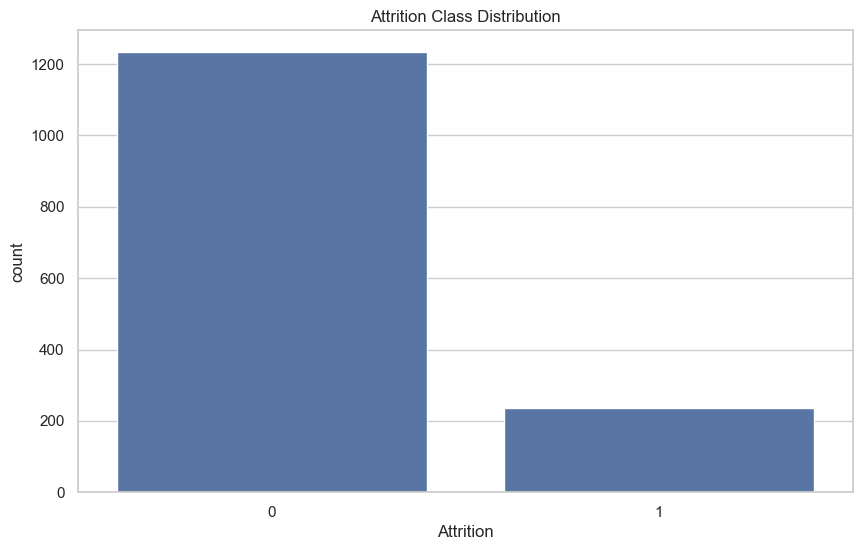

In [9]:
print("\nTarget Variable Distribution (Attrition):")
print(df['Attrition'].value_counts())
sns.countplot(data=df, x='Attrition')
plt.title('Attrition Class Distribution')
plt.show()

# Drop columns that have a single unique value or no impact

In [10]:

cols_to_drop = ['EmployeeCount', 'StandardHours', 'Over18']
df.drop(columns=cols_to_drop, inplace=True)

print("\nRemaining Columns After Cleanup:")
print(df.columns.tolist())


Remaining Columns After Cleanup:
['EmployeeNumber', 'Age', 'Gender', 'MaritalStatus', 'Education', 'EducationField', 'BusinessTravel', 'Department', 'JobRole', 'JobLevel', 'MonthlyIncome', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager', 'TotalWorkingYears', 'NumCompaniesWorked', 'TrainingTimesLastYear', 'PerformanceRating', 'PercentSalaryHike', 'StockOptionLevel', 'DistanceFromHome', 'JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'OverTime', 'Attrition', 'TargetRole', 'LeadershipScore', 'CulturalFitScore', 'PotentialRating', 'SuccessorReady']


#  FEATURE ENGINEERING

# Bucket 'YearsAtCompany' into tenure groups

In [11]:

def tenure_bucket(years):
    if years < 2:
        return '0-2 years'
    elif years < 5:
        return '2-5 years'
    elif years < 10:
        return '5-10 years'
    else:
        return '10+ years'

In [12]:
df['TenureBucket'] = df['YearsAtCompany'].apply(tenure_bucket)

# Create a 'HighPotentialFlag' based on multiple criteria

In [13]:

df['HighPotentialFlag'] = np.where(
    (df['PotentialRating'] == 2) &
    (df['LeadershipScore'] >= 4) &
    (df['CulturalFitScore'] >= 4),
    1, 0
)

# Flag employees at risk with no ready successor

In [14]:

df['CriticalRiskFlag'] = np.where(
    (df['Attrition'] == 1) & (df['SuccessorReady'] == 0),
    1, 0
)

# Create TenureBucket from YearsAtCompany
# Create HighPotentialFlag — mock logic (you can adjust thresholds)
# Create CriticalRiskFlag — mock logic (adjust based on your business logic)

In [15]:

df['TenureBucket'] = pd.cut(
    df['YearsAtCompany'],
    bins=[0, 3, 7, 20],
    labels=['Short', 'Medium', 'Long']
)


df['HighPotentialFlag'] = ((df['PerformanceRating'] >= 3) & (df['JobLevel'] <= 2)).astype(int)


df['CriticalRiskFlag'] = ((df['Attrition'] == 'Yes') & (df['JobLevel'] >= 3)).astype(int)


In [16]:
# Display new feature summary
print("\nFeature Engineering - New Columns Preview:")
print(df[['YearsAtCompany', 'TenureBucket', 'HighPotentialFlag', 'CriticalRiskFlag']].head())


Feature Engineering - New Columns Preview:
   YearsAtCompany TenureBucket  HighPotentialFlag  CriticalRiskFlag
0               6       Medium                  1                 0
1              10         Long                  1                 0
2               0          NaN                  1                 0
3               8         Long                  1                 0
4               2        Short                  1                 0


# EXPLORATORY DATA ANALYSIS (EDA)

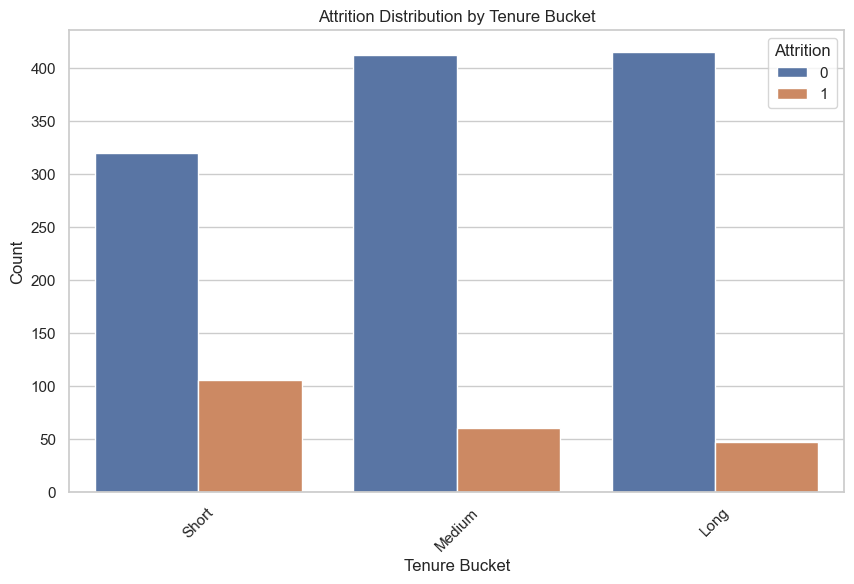

In [17]:
# Attrition by Tenure Bucket
sns.countplot(data=df, x='TenureBucket', hue='Attrition')
plt.title('Attrition Distribution by Tenure Bucket')
plt.xlabel('Tenure Bucket')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

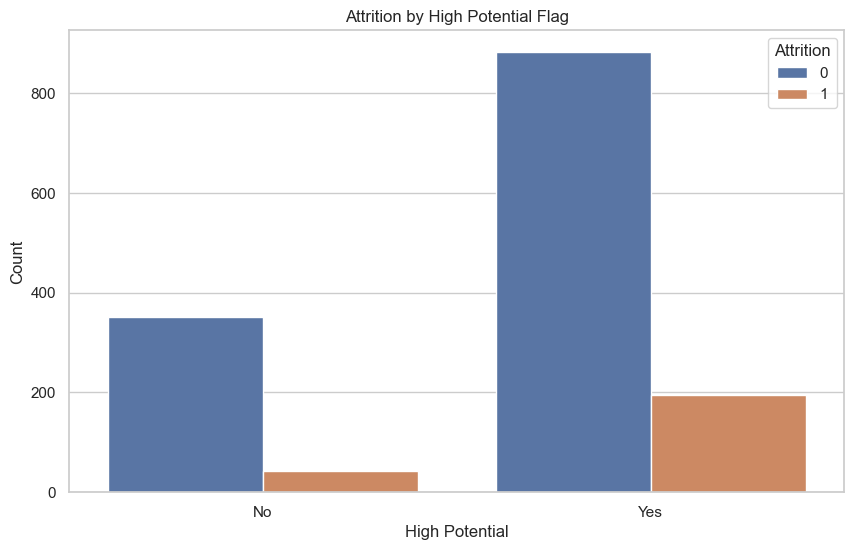

In [18]:
# Attrition vs HighPotentialFlag
sns.countplot(data=df, x='HighPotentialFlag', hue='Attrition')
plt.title('Attrition by High Potential Flag')
plt.xlabel('High Potential')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

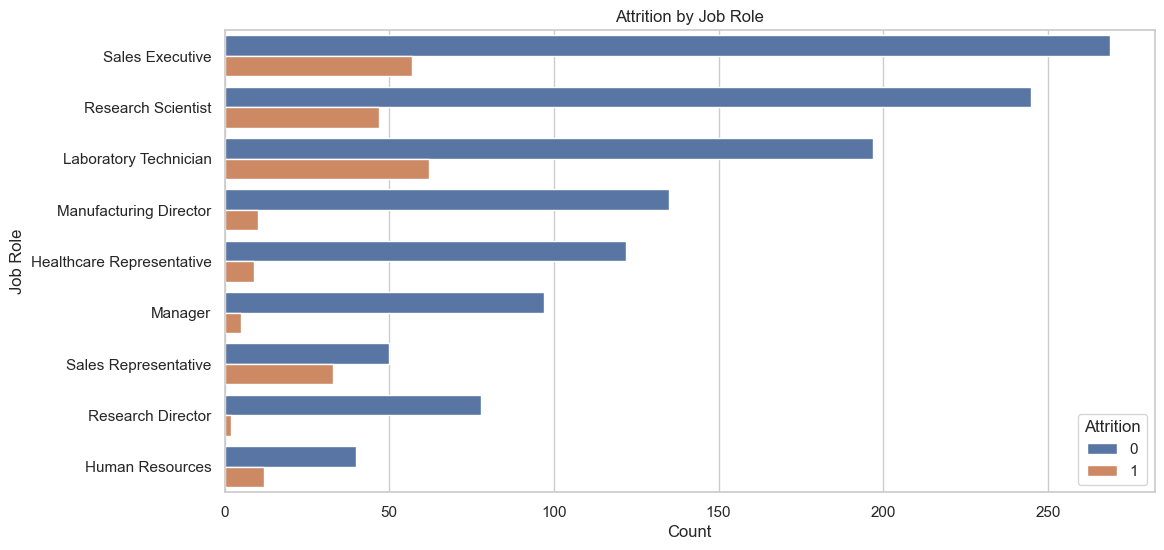

In [19]:
# Attrition vs Job Role
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='JobRole', hue='Attrition')
plt.title('Attrition by Job Role')
plt.ylabel('Job Role')
plt.xlabel('Count')
plt.show()

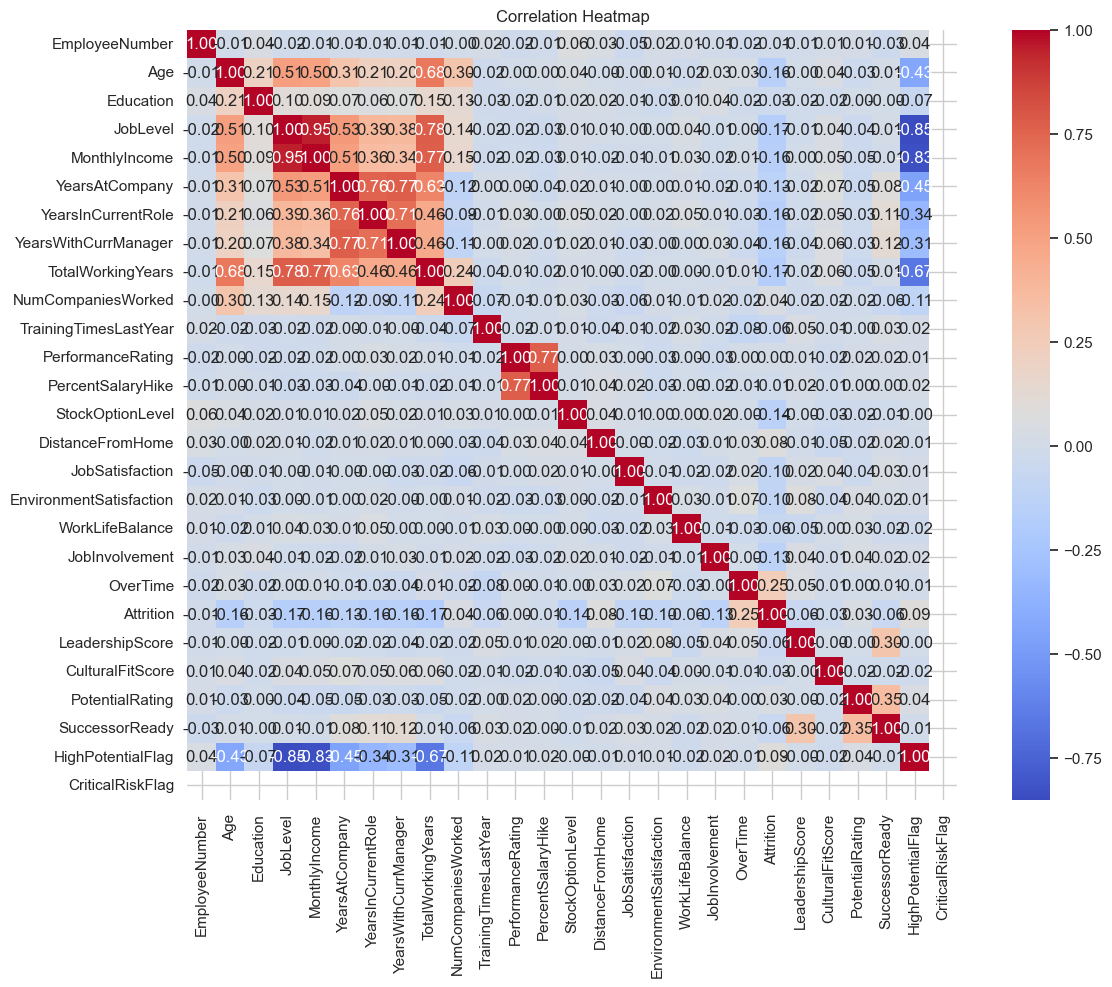

In [20]:
# Correlation Heatmap (only numeric features)
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(14, 10))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

#  DATA PREPROCESSING FOR MODELING

# One-hot encode categorical variables

In [21]:

df_model = pd.get_dummies(df, columns=['Gender', 'MaritalStatus', 'EducationField', 'BusinessTravel', 'Department', 'JobRole', 'TenureBucket', 'TargetRole'], drop_first=True)

# Define feature set and target variable

In [22]:
X = df_model.drop(columns=['Attrition'])
y = df_model['Attrition']

In [23]:
y.value_counts()

Attrition
0    1233
1     237
Name: count, dtype: int64

# Train-test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Balancing the train set

In [25]:
sm = SMOTE(random_state=42)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Standardize numerical features

In [26]:

scaler = StandardScaler()
numeric_cols = X_train_res.select_dtypes(include=[np.number]).columns
X_train_res[numeric_cols] = scaler.fit_transform(X_train_res[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Data shapes after preprocessing:

In [27]:
print("\nData shapes after preprocessing:")
print("X_train:", X_train_res.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train_res.shape)
print("y_test:", y_test.shape)


Data shapes after preprocessing:
X_train: (1972, 56)
X_test: (294, 56)
y_train: (1972,)
y_test: (294,)


#  MODEL TRAINING AND EVALUATION

# Standardize only numeric columns
# Reassign to avoid SettingWithCopyWarning

In [28]:

numeric_cols = X_train_res.select_dtypes(include=[np.number]).columns


X_train_res_scaled = X_train_res.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()
X_train_res_scaled[numeric_cols] = scaler.fit_transform(X_train_res[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


# Filter numeric columns and scale them

In [29]:

numeric_cols = X_train_res.select_dtypes(include=[np.number]).columns

In [30]:
scaler = StandardScaler()
X_train_res_scaled = X_train_res.copy()
X_test_scaled = X_test.copy()
X_train_res_scaled[numeric_cols] = scaler.fit_transform(X_train_res[numeric_cols])

# Save the scaler with joblib
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Keep only numeric columns in both training and testing sets
# Standardize numeric columns
# Train a Random Forest Classifier
# ✅ Save model for Streamlit app



Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       247
           1       0.40      0.36      0.38        47

    accuracy                           0.81       294
   macro avg       0.64      0.63      0.63       294
weighted avg       0.80      0.81      0.81       294


Confusion Matrix:


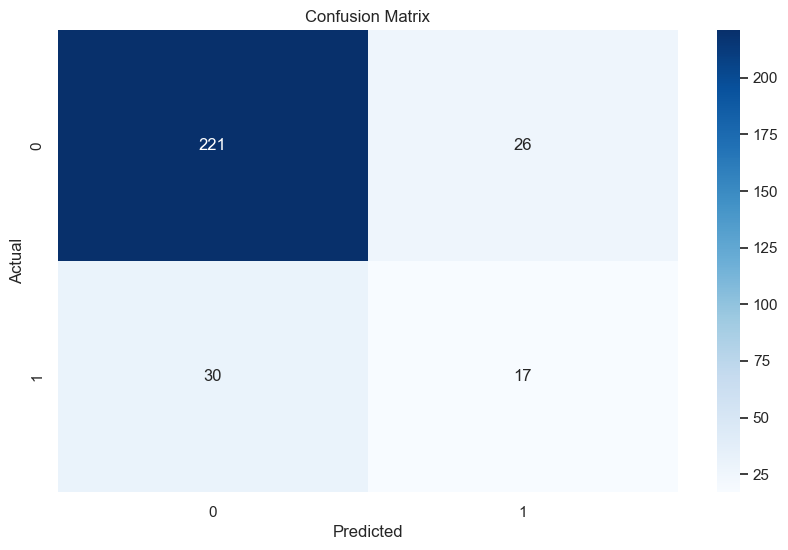


ROC AUC Score: 0.7374


In [31]:

X_train_res = X_train_res.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])


scaler = StandardScaler()
X_train_res_scaled = pd.DataFrame(scaler.fit_transform(X_train_res), columns=X_train_res.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# ✅ Save scaler for Streamlit app
import joblib
joblib.dump(scaler, "../scalers/standard_scaler.pkl")

# Gather new user data and create a PandasDataFrame. Transform the df in the same way.
X_new_user_data = pd.DataFrame([X_test.iloc[0]], columns=X_train_res.columns)
X_new_user_data_scaled = scaler.transform(X_new_user_data)

# Make sure that the user dataframe has the same columns as X_train and in the same order

# Load the scaler



# Define new user input with correct structure for testing
X_new_user_data = pd.DataFrame([X_test.iloc[0]], columns=X_train_res.columns)
X_new_user_data_scaled = scaler.transform(X_new_user_data)


# Rescale new data comming from streamlit
X_new_user_data_scaled = scaler.transform(X_new_user_data)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_res_scaled, y_train_res)

# ✅ Save model for Streamlit app
import joblib
joblib.dump(rf_model, "../model/rf_model.pkl")

# Predict on test data
y_pred = rf_model.predict(X_test_scaled)
y_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_score:.4f}")


# Predict on test data
# Evaluate the model


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       247
           1       0.40      0.36      0.38        47

    accuracy                           0.81       294
   macro avg       0.64      0.63      0.63       294
weighted avg       0.80      0.81      0.81       294


Confusion Matrix:


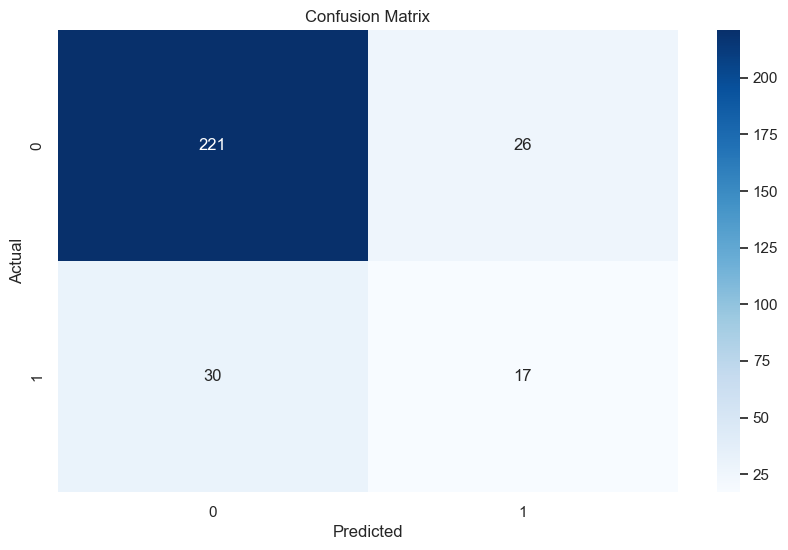


ROC AUC Score: 0.7374


In [32]:
# Predict on test data
y_pred = rf_model.predict(X_test_scaled)
y_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_score:.4f}")

# MODEL INTERPRETABILITY WITH SHAP

In [33]:
X_test_scaled[numeric_cols].to_numpy()


array([[ 0.78836405, -1.24136533, -0.75273305, ..., -0.2224734 ,
         0.5695426 ,  0.        ],
       [ 0.36000275,  0.96560585, -1.77503991, ...,  4.49491947,
         0.5695426 ,  0.        ],
       [-0.72896393, -0.46892542,  0.26957382, ..., -0.2224734 ,
        -1.7557949 ,  0.        ],
       ...,
       [ 1.19780176,  0.08281738,  2.31418755, ..., -0.2224734 ,
         0.5695426 ,  0.        ],
       [ 0.69546642,  2.28978856, -0.75273305, ..., -0.2224734 ,
         0.5695426 ,  0.        ],
       [-1.11087642,  0.19316594,  0.26957382, ..., -0.2224734 ,
         0.5695426 ,  0.        ]], shape=(294, 26))

<Figure size 1000x600 with 0 Axes>

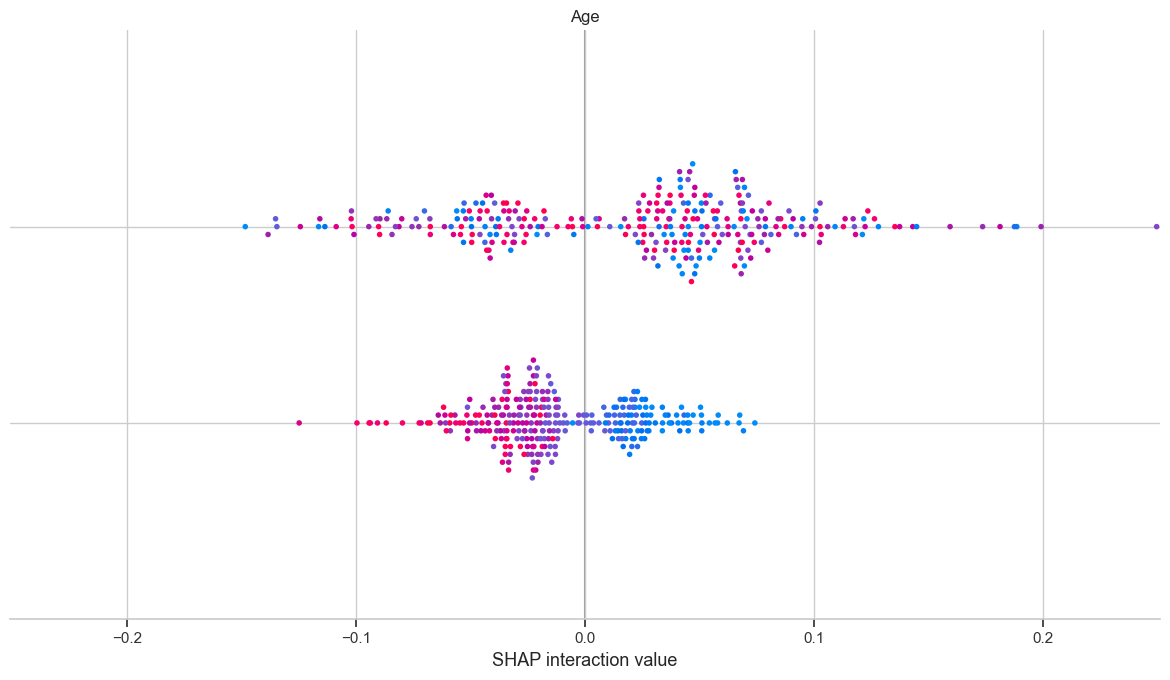

<Figure size 1000x600 with 0 Axes>

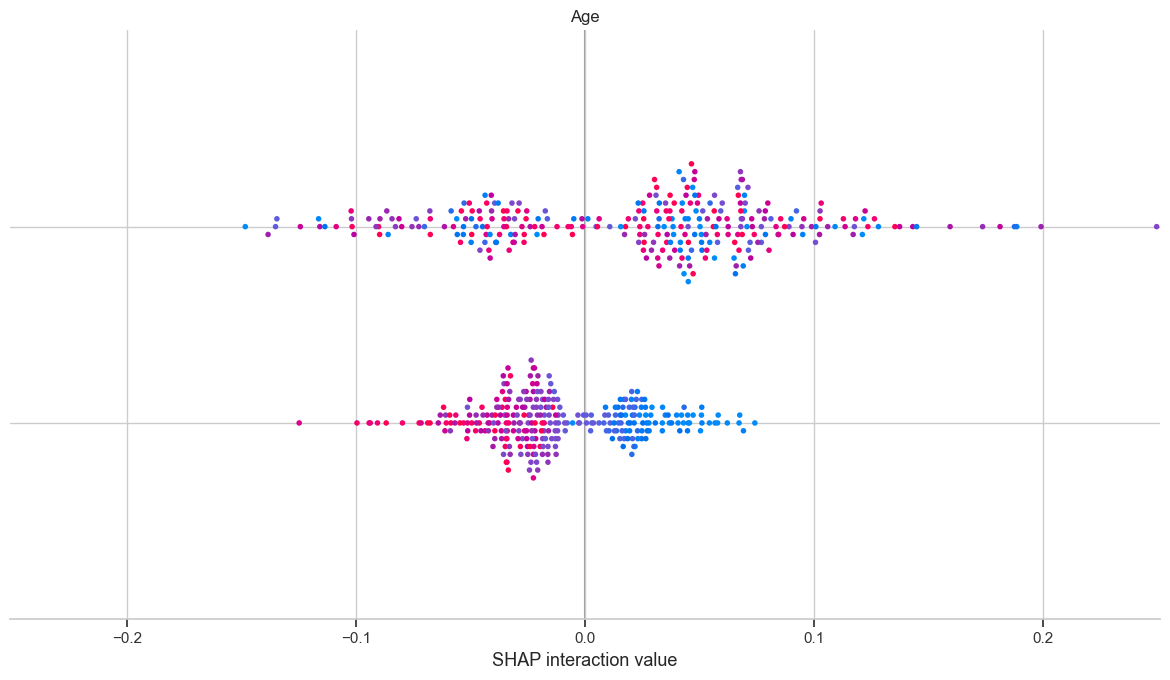

In [34]:
# Convert to array and ensure correct alignment with training columns
X_test_array = X_test_scaled[numeric_cols].to_numpy()

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_array)

# Safely extract SHAP values for binary classification
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_vals_to_plot = shap_values[1]  # Class 1 (Attrition=Yes)
    expected_value = explainer.expected_value[1]
else:
    shap_vals_to_plot = shap_values
    expected_value = explainer.expected_value

# Summary plot (global feature importance)
shap.summary_plot(shap_vals_to_plot, X_test_array, feature_names=numeric_cols.tolist(), plot_type="bar")

# Beeswarm plot for detailed impact
shap.summary_plot(shap_vals_to_plot, X_test_array, feature_names=numeric_cols.tolist())



MODEL TRAINING & Evaluation


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.04      0.08       247
           1       0.16      0.94      0.27        47

    accuracy                           0.18       294
   macro avg       0.46      0.49      0.17       294
weighted avg       0.67      0.18      0.11       294


Confusion Matrix:


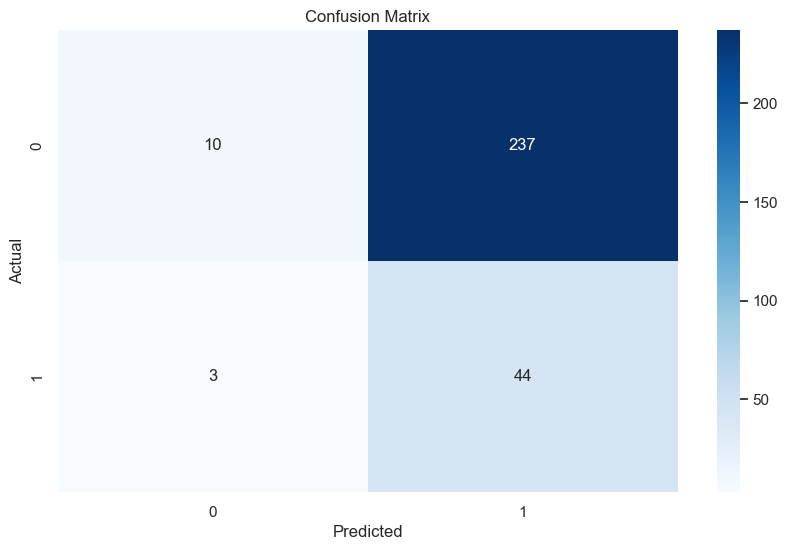


ROC AUC Score: 0.7599


In [35]:
 

# 📌 11. MODEL TRAINING AND EVALUATION

# Filter numeric columns and scale them
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled[numeric_cols], y_train)

# Predict on test data
y_pred = rf_model.predict(X_test_scaled[numeric_cols])
y_proba = rf_model.predict_proba(X_test_scaled[numeric_cols])[:, 1]

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_score:.4f}")

#  11.1 CORRELATION WITH ATTRITION


Top Features Most Correlated with Attrition:
MonthlyIncome                   0.064085
JobLevel                        0.055401
HighPotentialFlag              -0.053602
DistanceFromHome               -0.050666
JobRole_Research Director       0.047656
TargetRole_VP R&D               0.047656
SuccessorReady                 -0.045312
TenureBucket_Medium             0.044923
EducationField_Medical          0.044471
EducationField_Life Sciences   -0.043936
Name: Attrition, dtype: float64


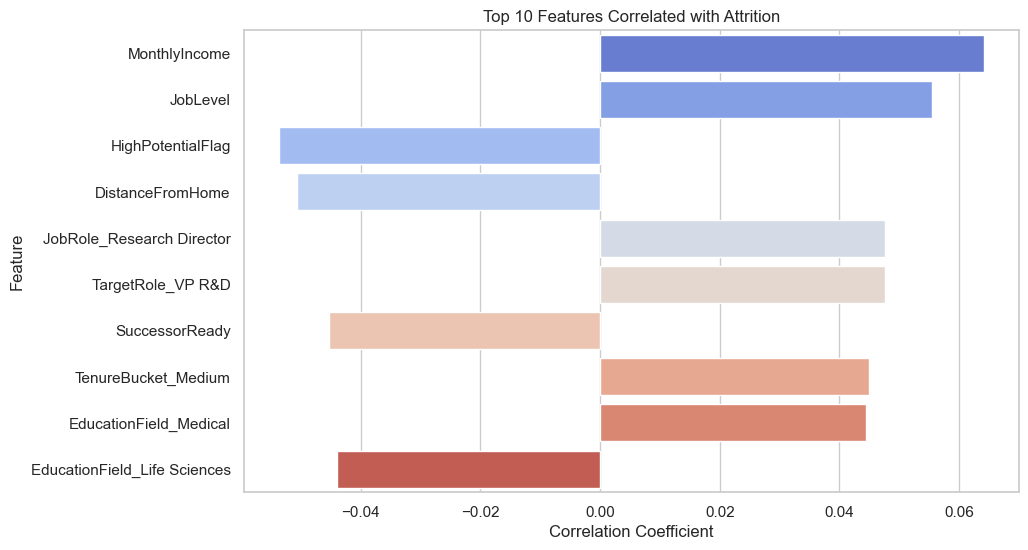

In [36]:
# Ensure 'Attrition' is numeric for correlation
X_train_scaled_with_target = X_train_scaled.copy()
y_train_numeric = y_train.map({'Yes': 1, 'No': 0}) if y_train.dtype == 'object' else y_train
X_train_scaled_with_target['Attrition'] = y_train_numeric.reset_index(drop=True)

# Compute correlations
correlations = X_train_scaled_with_target.corr()['Attrition'].drop('Attrition').sort_values(key=abs, ascending=False)

print("\nTop Features Most Correlated with Attrition:")
print(correlations.head(10))

# Visualize top 10 correlated features
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.head(10).values, y=correlations.head(10).index, hue=correlations.head(10).index, palette="coolwarm", legend=False)
plt.title("Top 10 Features Correlated with Attrition")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()


 CORRELATION COMPARISON BY GROUP

Departments included in correlation analysis:
['Sales' 'Research & Development' 'Human Resources']
Top Correlated Features Grouped by Department:
PotentialRating            0.998976
EnvironmentSatisfaction   -0.974389
PercentSalaryHike         -0.973487
DistanceFromHome           0.886075
WorkLifeBalance            0.866363
Education                  0.826828
LeadershipScore            0.702314
TotalWorkingYears         -0.593916
PerformanceRating         -0.524672
OverTime                  -0.523128
dtype: float64


/Users/Devika/Desktop/IronHack/finalproject/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/Devika/Desktop/IronHack/finalproject/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


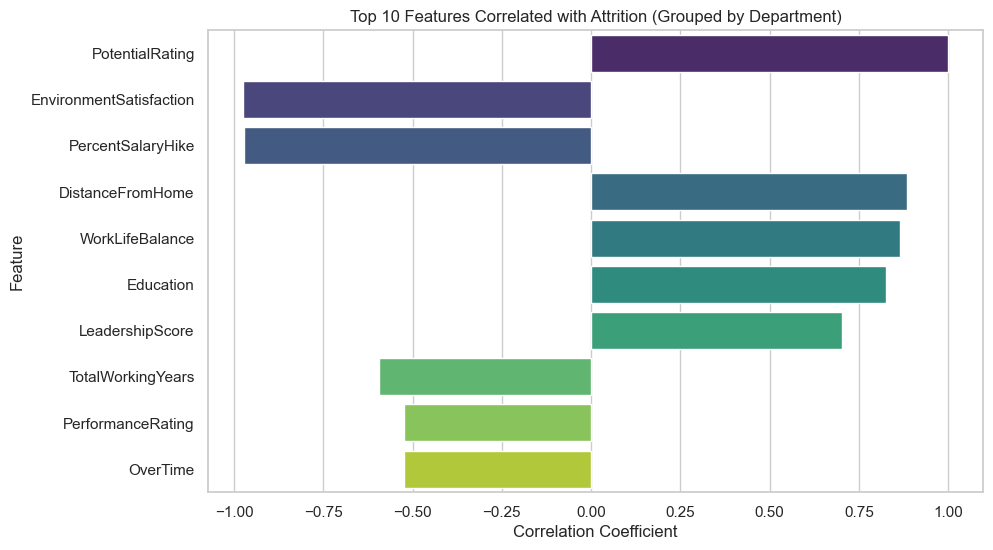

In [37]:

# 📌 11.2 CORRELATION COMPARISON BY DEPARTMENT

# Merge Department back with X_train
y_train_numeric = y_train.map({'Yes': 1, 'No': 0}) if y_train.dtype == 'object' else y_train
X_train_with_dept = X_train.copy()
X_train_with_dept['Department'] = df.loc[X_train.index, 'Department'].values
X_train_with_dept['Attrition'] = y_train_numeric.values

# Display departments used in analysis
print("Departments included in correlation analysis:")
print(X_train_with_dept['Department'].unique())

# Compute mean attrition by department
dept_mean_attrition = X_train_with_dept.groupby('Department')['Attrition'].mean()

# Compute mean feature values per department
dept_mean_features = X_train_with_dept.groupby('Department')[numeric_cols].mean().replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='any')

# Correlate mean feature values with mean attrition per department
dept_corr = dept_mean_features.corrwith(dept_mean_attrition).sort_values(key=abs, ascending=False)

print("Top Correlated Features Grouped by Department:")
print(dept_corr.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=dept_corr.head(10).values, y=dept_corr.head(10).index, hue=dept_corr.head(10).index, palette="viridis", legend=False)
plt.title("Top 10 Features Correlated with Attrition (Grouped by Department)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

In [38]:
import xgboost as xgb

In [40]:
data = pd.DataFrame(np.arange(12).reshape((4,3)), columns=['a', 'b', 'c'])
label = pd.DataFrame(np.random.randint(2, size=4))
dtrain = xgb.DMatrix(data, label=label)

In [41]:
from xgboost import XGBClassifier

# Initialize the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train_res_scaled, y_train_res)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate performance
from sklearn.metrics import classification_report, accuracy_score

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.19387755102040816
              precision    recall  f1-score   support

           0       1.00      0.04      0.08       247
           1       0.17      1.00      0.28        47

    accuracy                           0.19       294
   macro avg       0.58      0.52      0.18       294
weighted avg       0.87      0.19      0.11       294



/Users/Devika/Desktop/IronHack/finalproject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:38:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Check Class Balance

In [42]:
print(y_train.value_counts())
print(y_test.value_counts())


Attrition
0    986
1    190
Name: count, dtype: int64
Attrition
0    247
1     47
Name: count, dtype: int64


In [43]:
train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


[      EmployeeNumber  Age  Education  JobLevel  MonthlyIncome  YearsAtCompany  \
 1194            1676   47          4         4          15972               3   
 128              169   22          1         1           2523               2   
 810             1124   46          1         4          17465              12   
 478              645   25          1         1           2096               7   
 491              663   43          5         2           5679               8   
 ...              ...  ...        ...       ...            ...             ...   
 1213            1702   23          3         1           2275               3   
 963             1355   38          2         2           6893               7   
 734             1019   22          1         1           2451               4   
 1315            1847   36          4         2           6962               1   
 1292            1812   39          3         2           4127               2   
 
       YearsIn

In [45]:
from xgboost import XGBClassifier

# Calculate class imbalance ratio
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# Initialize model with class imbalance handling
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)


In [46]:
xgb_model.fit(X_train_scaled, y_train)


/Users/Devika/Desktop/IronHack/finalproject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:42:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [47]:
print(f"Negative: {neg}, Positive: {pos}, Ratio: {scale_pos_weight:.2f}")


Negative: 986, Positive: 190, Ratio: 5.19


In [48]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=5.19
)


In [50]:
X_train = pd.get_dummies(X_train, drop_first=False)
X_test = pd.get_dummies(X_test, drop_first=False)

# Align both to have same columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


In [51]:
from sklearn.metrics import classification_report, accuracy_score

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.19387755102040816
              precision    recall  f1-score   support

           0       1.00      0.04      0.08       247
           1       0.17      1.00      0.28        47

    accuracy                           0.19       294
   macro avg       0.58      0.52      0.18       294
weighted avg       0.87      0.19      0.11       294



In [53]:
# Encode full dataset before split
df_model = pd.get_dummies(df_model, drop_first=True)

# Train-test split
X = df_model.drop('Attrition', axis=1)
y = df_model['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Align train and test features (critical!)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [54]:
# Scale only numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric_cols]), columns=numeric_cols)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric_cols]), columns=numeric_cols)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.74      0.83       309
           1       0.34      0.69      0.46        59

    accuracy                           0.74       368
   macro avg       0.63      0.72      0.64       368
weighted avg       0.83      0.74      0.77       368

📉 Confusion Matrix:


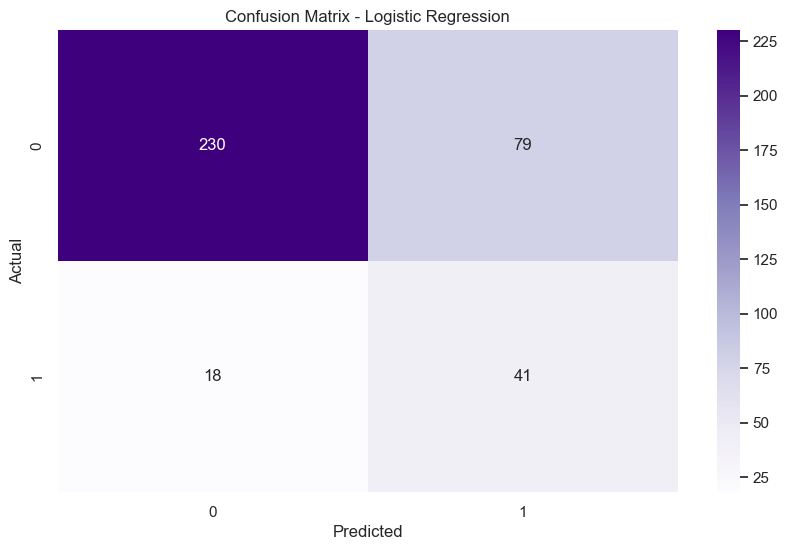

🔥 ROC AUC Score: 0.7945


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train logistic regression model
log_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_model.fit(X_train_scaled, y_train)

# Predict
y_pred_log = log_model.predict(X_test_scaled)
y_proba_log = log_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("📊 Classification Report:")
print(classification_report(y_test, y_pred_log))

print("📉 Confusion Matrix:")
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC AUC
roc_score_log = roc_auc_score(y_test, y_proba_log)
print(f"🔥 ROC AUC Score: {roc_score_log:.4f}")


In [57]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

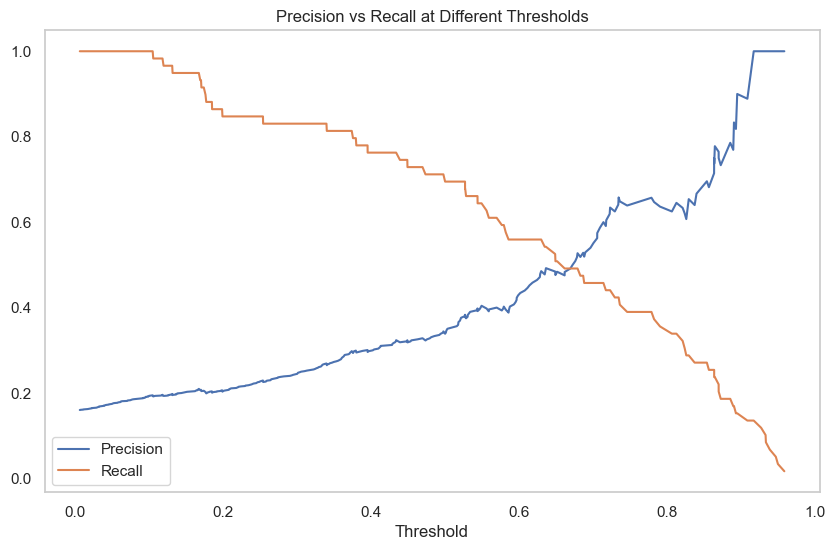

In [58]:
from sklearn.metrics import precision_recall_curve

y_proba = log_model.predict_proba(X_test_scaled)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Plot to find sweet spot
import matplotlib.pyplot as plt
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid()
plt.title('Precision vs Recall at Different Thresholds')
plt.show()


In [59]:
optimal_threshold = 0.4  # example
y_pred_custom = (y_proba >= optimal_threshold).astype(int)


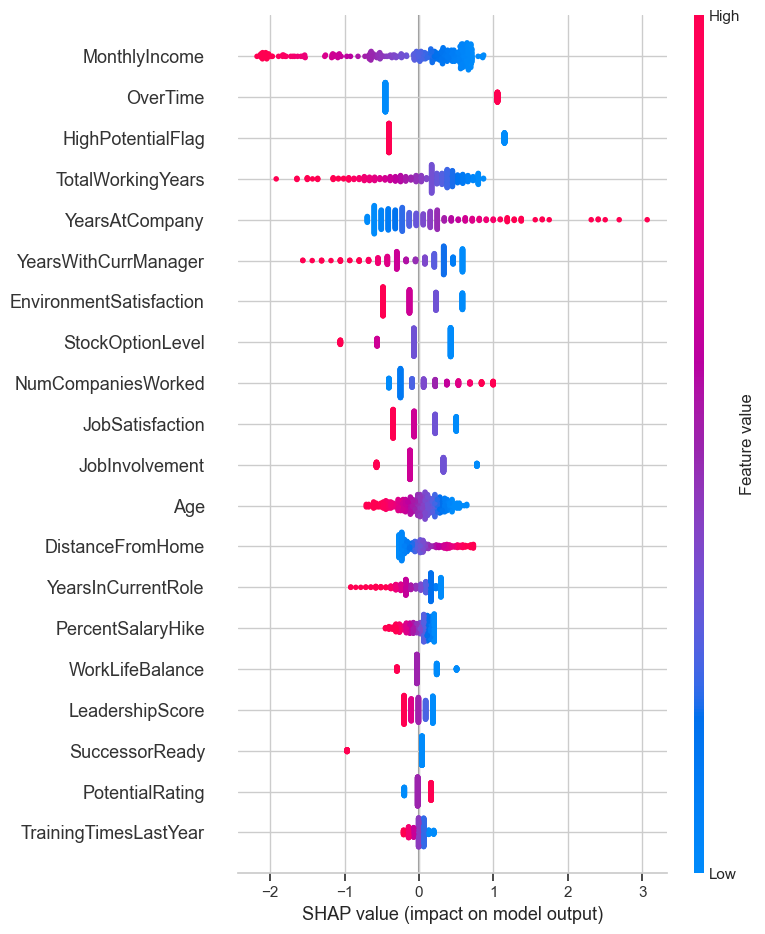

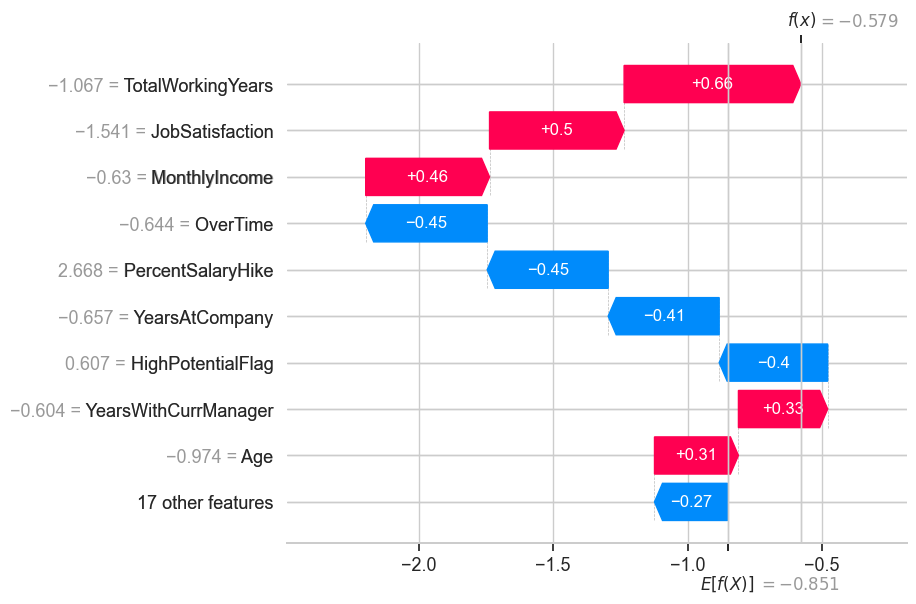

In [60]:
import shap

explainer = shap.Explainer(log_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

# Waterfall plot for a single prediction
shap.plots.waterfall(shap_values[0])


In [61]:
threshold = st.sidebar.slider("Select classification threshold", 0.0, 1.0, 0.5, 0.01)
y_pred = (y_proba >= threshold).astype(int)


NameError: name 'st' is not defined

/var/folders/8w/8drmpp8x5pd_qdpy7j5kkknc0000gp/T/ipykernel_18749/3363218084.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)


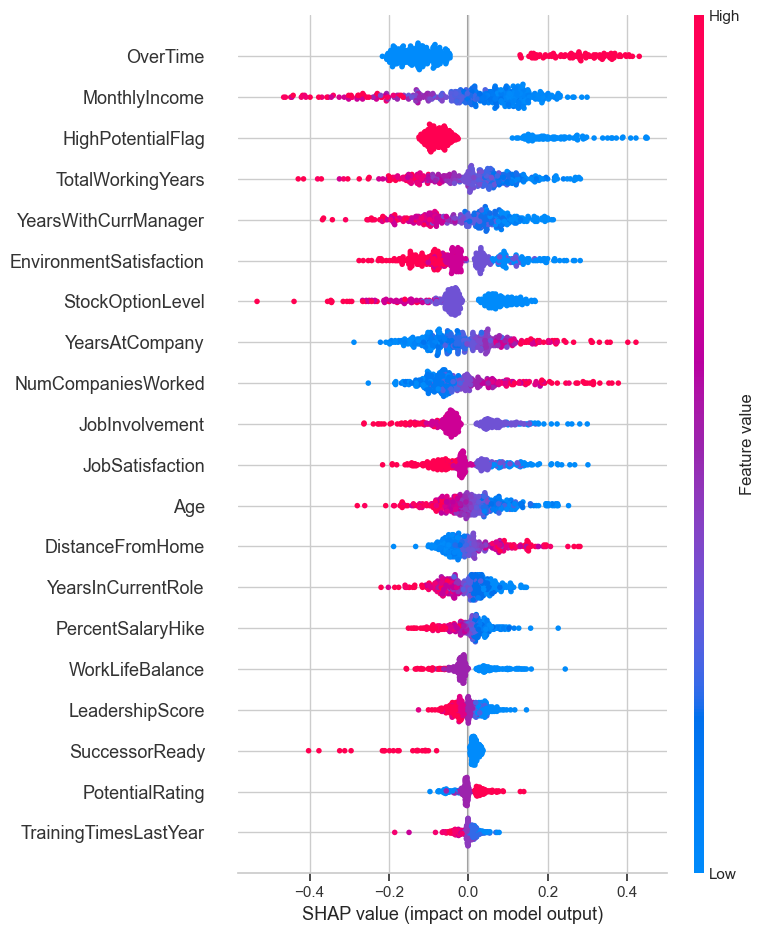

In [62]:
import shap
import matplotlib.pyplot as plt

# Train your Logistic Regression model as you already have
# log_model = LogisticRegression(...).fit(X_train_scaled, y_train)

# Use SHAP KernelExplainer for logistic regression
explainer = shap.Explainer(log_model.predict, X_test_scaled)
shap_values = explainer(X_test_scaled)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)
